### Training Word2vec From Brown Dataset 

In [3]:
import gensim
from nltk.corpus import brown
# import logging
# logging.basicConfig(
#     format='%(levelname)s : %(message)s', level=logging.INFO)
dim = [25, 100, 300]
wind = [2, 7, 15]
neg = [1, 7, 20]
for i in dim:
    for j in wind:
        for k in neg:
            print(i,j,k)
            model = gensim.models.Word2Vec(brown.sents(),
                                            vector_size=i,
                                            window=j,
                                            negative=k,
                                            epochs=10
                                            )
            model.save('./model/brown_d(%d)_w(%d)_n(%d).embedding' %(i,j,k))

25 2 1
25 2 7
25 2 20
25 7 1
25 7 7
25 7 20
25 15 1
25 15 7


KeyboardInterrupt: 

In [8]:
import itertools
from gensim.models.word2vec import Text8Corpus
# from glove import Glove
from mittens import GloVe
from nltk.corpus import brown

ImportError: cannot import name 'Corpus' from 'mittens' (c:\Users\meghd\Anaconda3\envs\nlp\lib\site-packages\mittens\__init__.py)

In [7]:
sentences = list(itertools.islice(Text8Corpus(brown.sents()),None))

TypeError: don't know how to handle uri [['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]

Rounding

In [73]:
def evaluation(model_evalu):
    acc = round(model_evalu[0][0],6)
    acc = acc*100
    return acc

### Functions For Evaluation of Bats

In [54]:
import numpy as np
from numpy.linalg import norm
import random
import os

def collect(model):
    if type(model) is dict:
        vocab = [k for k in model.keys()]
    else:
        vocab = [k for k in model.wv.key_to_index.keys()]

    indices = {}
    for i in range(len(vocab)): indices[vocab[i]] = i
        
    matrix = []
    for w in vocab:
        matrix.append(model.wv[w])
    return np.array(matrix), vocab, indices

def eval_bats_file(model, matrix, vocab, indices, f, repeat=False, multi=0):
    pairs = [line.strip().split() for line in open(f, 'r').readlines()]

    # discard pairs that are not in our vocabulary
    pairs = [[p[0], p[1].split('/')] for p in pairs if p[0] in model.wv]
    pairs = [[p[0], [w for w in p[1] if w in model.wv]] for p in pairs]
    pairs = [p for p in pairs if len(p[1]) > 0]
    if len(pairs) <= 1: return None

    transposed = np.transpose(np.array([x / norm(x) for x in matrix]))
    
    if not multi:
        qa = []
        qb = []
        qc = []
        targets = []
        exclude = []
        groups = []
        for i in range(len(pairs)):
            j = random.randint(0, len(pairs) - 2)
            if j >= i: j += 1
            a = model.wv[pairs[i][0]]
            c = model.wv[pairs[j][0]]
            for bw in pairs[i][1]:
                qa.append(a)
                qb.append(model.wv[bw])
                qc.append(c)
                groups.append(i)
                targets.append(pairs[j][1])
                exclude.append([pairs[i][0], bw, pairs[j][0]])

        for queries in [qa, qb, qc]:
            queries = np.array([x / norm(x) for x in queries])
        sa = np.matmul(qa, transposed) + .0001
        sb = np.matmul(qb, transposed)
        sc = np.matmul(qc, transposed)
        sims = sb + sc - sa
        # exclude original query words from candidates
        for i in range(len(exclude)):
            for w in exclude[i]:
                sims[i][indices[w]] = 0

    else:
        offsets = []
        exclude = []
        preds = []
        targets = []
        groups = []
        
        for i in range(len(pairs) // multi):
            qa = [pairs[j][0] for j in range(len(pairs)) if j - i not in range(multi)]
            qb = [[w for w in pairs[j][1] if w in model] for j in range(len(pairs)) if j - i not in range(multi)]
            qbs = []
            for ws in qb: qbs += ws
            a = np.mean([model[w] for w in qa], axis=0)
            b = np.mean([np.mean([model[w] for w in ws], axis=0) for ws in qb], axis=0)
            a = a / norm(a)
            b = b / norm(b)

            for k in range(multi):
                c = model[pairs[i + k][0]]
                c = c / norm(c)
                offset = b + c - a
                offsets.append(offset / norm(offset))
                targets.append(pairs[i + k][1])
                exclude.append(qa + qbs + [pairs[i + k][0]])
                groups.append(len(groups))

        print(np.shape(transposed))
        sims = np.matmul(np.array(offsets), transposed)
        print(np.shape(sims))
        for i in range(len(exclude)):
            for w in exclude[i]:
                sims[i][indices[w]] = 0

    preds = [vocab[np.argmax(x)] for x in sims]
    accs = [1 if preds[i].lower() in targets[i] else 0 for i in range(len(preds))]
    regrouped = np.zeros(np.max(groups) + 1)
    for a, g in zip(accs, groups):
        regrouped[g] = max(a, regrouped[g])
    return np.mean(regrouped)

def eval_bats(model, matrix, vocab, indices):
    accs = {}
    base = './evaluation/bats'
    for dr in os.listdir('./evaluation/bats'):
        if os.path.isdir(os.path.join(base, dr)):
            dk = dr.split('_', 1)[1].lower()
            accs[dk] = []
            for f in os.listdir(os.path.join(base, dr)):
                accs[f.split('.')[0]] = eval_bats_file(model, matrix, vocab, indices, os.path.join(base, dr, f))
                accs[dk].append(accs[f.split('.')[0]])
            accs[dk] = [a for a in accs[dk] if a is not None]
            accs[dk] = np.mean(accs[dk]) if len(accs[dk]) > 0 else None

    accs['total'] = np.mean([accs[k] for k in accs.keys() if accs[k] is not None])

    return accs

## Evaluation of Bats

In [60]:
def evalu_bats(model):
    bats_cat_1 = "lexicographic_semantics"
    bats_cat_2 = "E10 [male - female]"
    bats_cat_3 = "total"

    matrix, vocab, indices = collect(model)
    bats = eval_bats(model, matrix, vocab, indices)
    bat1 = round(bats[bats_cat_1],6)
    bat2 = round(bats[bats_cat_2],6)
    bat3 = round(bats[bats_cat_3],6)
    result_bats = [bat1,bat2,bat3]
    
    return result_bats

### Initialing Tabel Headers

In [66]:
header = ['Algorithm', 'Win', 'Dim', 'NS','wordsim353','BAT1','BAT2','Bat3','win353']

# prepare accuracy of models

In [74]:
import gensim
data = []
dim = [25, 100, 300]
wind = [2, 7, 15]
neg = [1, 7, 20]
for i in dim:
    for j in wind:
        for k in neg:
            new_model = gensim.models.Word2Vec.load('./model/brown_d(%d)_w(%d)_n(%d).embedding' %(i,j,k))
            model_evalu_wordsim353= new_model.wv.evaluate_word_pairs('./evaluation/wordsim353.tsv')
            model_evalu_win353= new_model.wv.evaluate_word_pairs('./evaluation/win353.tsv')
            bats_list = evalu_bats(new_model)
            data.append(['Word2Vec',i,j,k,evaluation(model_evalu_wordsim353),bats_list[0],bats_list[1],bats_list[2],evaluation(model_evalu_win353)],)
            print(i,j,k,"=>","wordsim353: ",evaluation(model_evalu_wordsim353),
                  " win353: ",evaluation(model_evalu_win353),
                  " BAT1: ",bats_list[0],
                  "BAT2 ",bats_list[1],
                  "BAT3",bats_list[2])

25 2 1 => wordsim353:  13.0802  win353:  12.2082  BAT1:  0.025163 BAT2  0.285714 BAT3 0.02938
25 2 7 => wordsim353:  13.0435  win353:  12.2053  BAT1:  0.022627 BAT2  0.214286 BAT3 0.030254
25 2 20 => wordsim353:  13.05  win353:  12.185  BAT1:  0.031017 BAT2  0.142857 BAT3 0.028315
25 7 1 => wordsim353:  12.8822  win353:  12.1052  BAT1:  0.040281 BAT2  0.214286 BAT3 0.033563
25 7 7 => wordsim353:  12.778500000000001  win353:  12.0117  BAT1:  0.011525 BAT2  0.285714 BAT3 0.025896
25 7 20 => wordsim353:  13.1352  win353:  12.3628  BAT1:  0.030755 BAT2  0.142857 BAT3 0.035561
25 15 1 => wordsim353:  12.97  win353:  12.0762  BAT1:  0.031715 BAT2  0.214286 BAT3 0.032998
25 15 7 => wordsim353:  13.013  win353:  12.1969  BAT1:  0.03183 BAT2  0.285714 BAT3 0.025944
25 15 20 => wordsim353:  12.958300000000001  win353:  12.1617  BAT1:  0.022838 BAT2  0.071429 BAT3 0.018002
100 2 1 => wordsim353:  12.948699999999999  win353:  12.1829  BAT1:  0.045067 BAT2  0.142857 BAT3 0.038776
100 2 7 => wordsim

## Make accuracy as csv file

In [75]:
import csv
with open('./result/models_results.csv', 'w') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(data)

### Make table

In [76]:
import plotly.graph_objects as go
import pandas as pd
# ['Algorithm', 'Win', 'Dim', 'NS','wordsim353','BAT1','BAT2','Bat3','win353']
df = pd.read_csv('./result/models_results.csv')
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df.Algorithm, df.Win, df.Dim, df.NS, df.wordsim353,df.BAT1,df.BAT2,df.Bat3, df.win353],
               fill_color='lavender',
               align='left'))
])

fig.show()

## Part 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=10).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


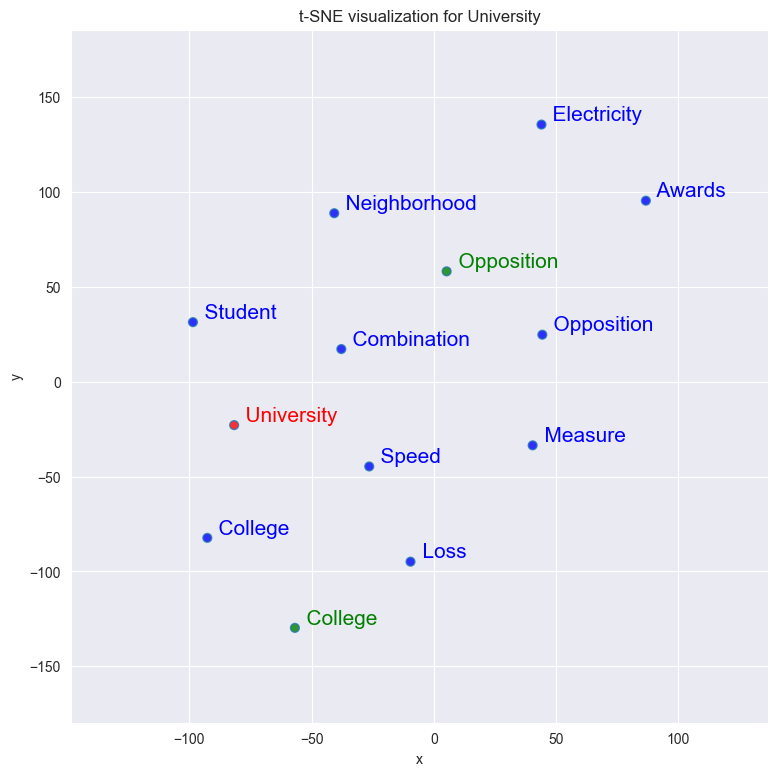

In [20]:
import gensim
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')
tsnescatterplot(new_model, 'university', ['college', 'opposition'])

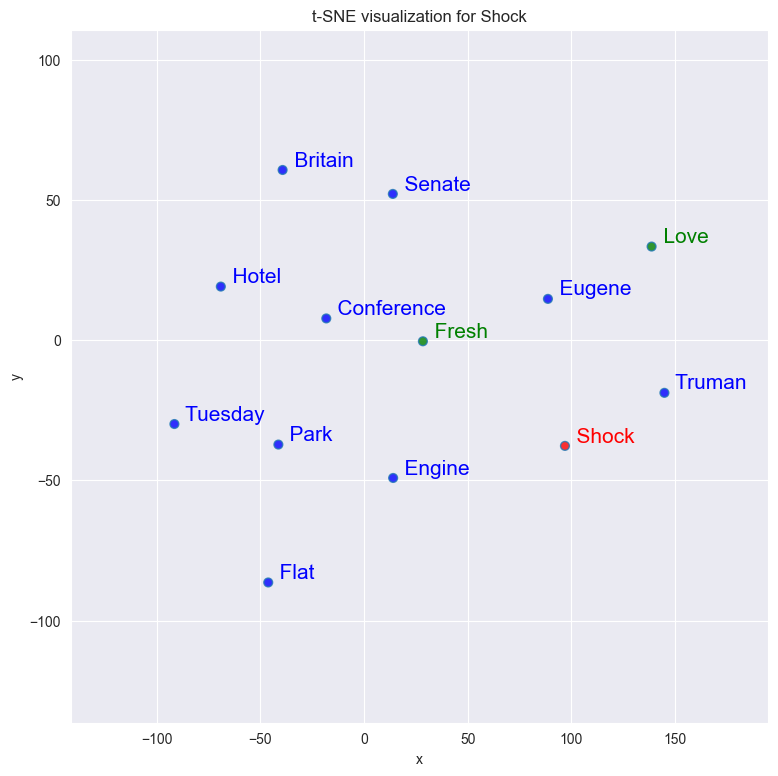

In [14]:
import gensim
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')
tsnescatterplot(new_model, 'shock', ['fresh', 'Love'])

In [7]:
def clean_reviews(no_reviews,language, words_to_be_excluded, words_to_be_included, dataset):
    import re
    import nltk
    nltk.download('stopwords') #Must only be downloaded once 
    from nltk.corpus import stopwords #Includes a list of words that souldn't appear in the reivews
    
    #Create own list of stopwords
    my_stopwords = stopwords.words(language) 
    #Append the words from to_be_excluded_words to my_stopwords
    for word in words_to_be_excluded:
        if not any ( word in stpwords for stpwords in my_stopwords):
            my_stopwords.append(word)
    
    #Remove words from my_stopwords that are present in to_be_included
    for word in words_to_be_included:
        if any (word in stpwords for stpwords in my_stopwords):
            my_stopwords.remove(word)
            
    #Stemming is the process of extracting the stem of each word e.g. "loved"->"love"
    from nltk.stem.porter import PorterStemmer
     
    corpus =[] #Will contain the clean reviews"
    for i in range (0, no_reviews):
        review = re.sub('[^a-zA-Z]',' ', dataset['Review'][i]) #Removes all other characters besides the letters and puts the review in a string
        review = review.lower() #Transforms all UPPER-CASE characters to lower-case
        review = review.split() #Separates all the words from the review string and puts them in a list
        ps = PorterStemmer() 
        review = [ps.stem(word) for word in review if not word in set (my_stopwords)] #Remove irrelevant words from rewiews and stems all words  
        review = ' '.join(review) 
        corpus.append(review) #Append review string to corpus
    return corpus

In [52]:
path = './dataset/Restaurant_Reviews.tsv'
dataset = pd.read_csv(path, delimiter = '\t', quoting = 3)
language = 'english' #You can find the list of accepted languages in the README.md file
words_to_be_included = ['not','nor','no'] #That should be part the reviews
words_to_be_excluded = ['opinion'] #That shouldn't be part of the reviews
no_reviews = 1000
maximum_features = 1500 #Maximum elements that the Bag of Words could contain
test_set_size = 0.2
corpus = clean_reviews(no_reviews,language,words_to_be_excluded,words_to_be_included,dataset)   

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meghd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
type(corpus[0])
list_word =[]
for sen in corpus:
    token = sen.split(" ")
    for word in token:
        list_word.append(word)
print(list_word)

['wow', 'love', 'place', 'crust', 'not', 'good', 'not', 'tasti', 'textur', 'nasti', 'stop', 'late', 'may', 'bank', 'holiday', 'rick', 'steve', 'recommend', 'love', 'select', 'menu', 'great', 'price', 'get', 'angri', 'want', 'damn', 'pho', 'honeslti', 'tast', 'fresh', 'potato', 'like', 'rubber', 'could', 'tell', 'made', 'ahead', 'time', 'kept', 'warmer', 'fri', 'great', 'great', 'touch', 'servic', 'prompt', 'would', 'not', 'go', 'back', 'cashier', 'no', 'care', 'ever', 'say', 'still', 'end', 'wayyy', 'overpr', 'tri', 'cape', 'cod', 'ravoli', 'chicken', 'cranberri', 'mmmm', 'disgust', 'pretti', 'sure', 'human', 'hair', 'shock', 'no', 'sign', 'indic', 'cash', 'highli', 'recommend', 'waitress', 'littl', 'slow', 'servic', 'place', 'not', 'worth', 'time', 'let', 'alon', 'vega', 'not', 'like', 'burritto', 'blah', 'food', 'amaz', 'servic', 'also', 'cute', 'could', 'care', 'less', 'interior', 'beauti', 'perform', 'right', 'red', 'velvet', 'cake', 'ohhh', 'stuff', 'good', 'never', 'brought', 'sa

In [70]:
import random
shuffle = []
for i in range(6):
    shuffle.append(list_word[random.randint(0,len(list_word))])
print(shuffle)

['short', 'love', 'light', 'manag', 'sinc', 'fresh']


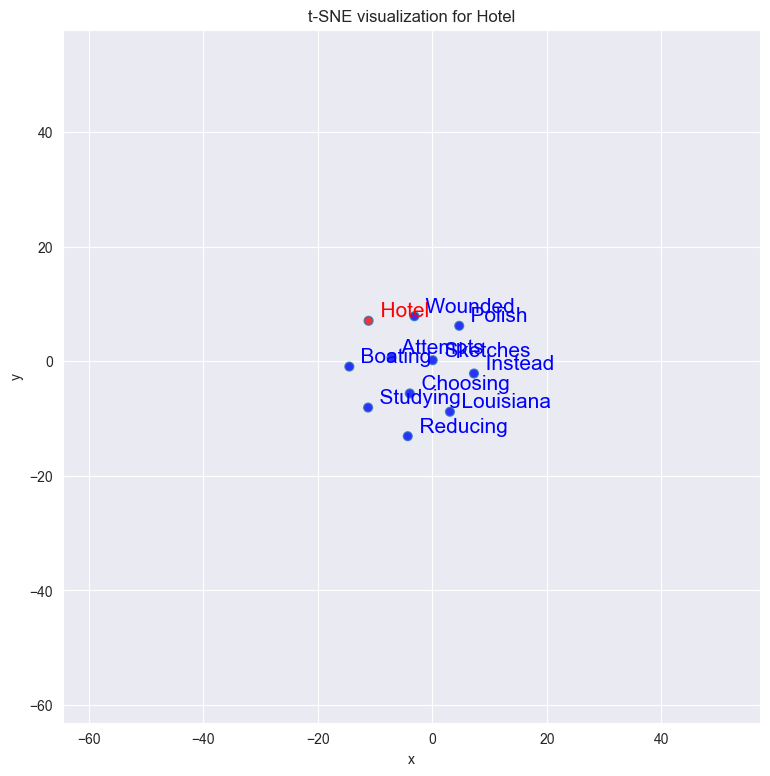

In [79]:
import gensim
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')
tsnescatterplot(new_model, 'hotel',[])
#['short', 'love', 'light','sinc', 'fresh']

In [80]:
new_model.wv.most_similar("hotel")

[('Louisiana', 0.9974067211151123),
 ('Instead', 0.9974024295806885),
 ('studying', 0.996891438961029),
 ('sketches', 0.9968657493591309),
 ('wounded', 0.9968023300170898),
 ('choosing', 0.9967365264892578),
 ('polish', 0.9967051148414612),
 ('attempts', 0.9966889023780823),
 ('boating', 0.9965800046920776),
 ('reducing', 0.9965658783912659)]

In [88]:
keys = ['Paris', 'Sunday',   'delivery', 'election', 'expensive',
        'experience', 'financial', 'food',  'peace', 'release', 'war']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in new_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(new_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [89]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [91]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
% matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_en_2d, word_clusters)

UsageError: Line magic function `%` not found.


In [92]:
prepare_for_w2v('data/Anna Karenina by Leo Tolstoy (ru).txt', 'train_anna_karenina_ru.txt', 'russian')
model_ak = train_word2vec('train_anna_karenina_ru.txt')

words = []
embeddings = []
for word in list(model_ak.wv.vocab):
    embeddings.append(model_ak.wv[word])
    words.append(word)
    
tsne_ak_2d = TSNE(n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_ak_2d = tsne_ak_2d.fit_transform(embeddings)

NameError: name 'prepare_for_w2v' is not defined

In [93]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=10)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_2d('Anna Karenina by Leo Tolstoy', embeddings_ak_2d, a=0.1)

NameError: name 'embeddings_ak_2d' is not defined

In [127]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.index_to_key[:100]:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tokens = np.asarray(tokens)
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=8)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    print(len(x))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        print(i)
    plt.show()

100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


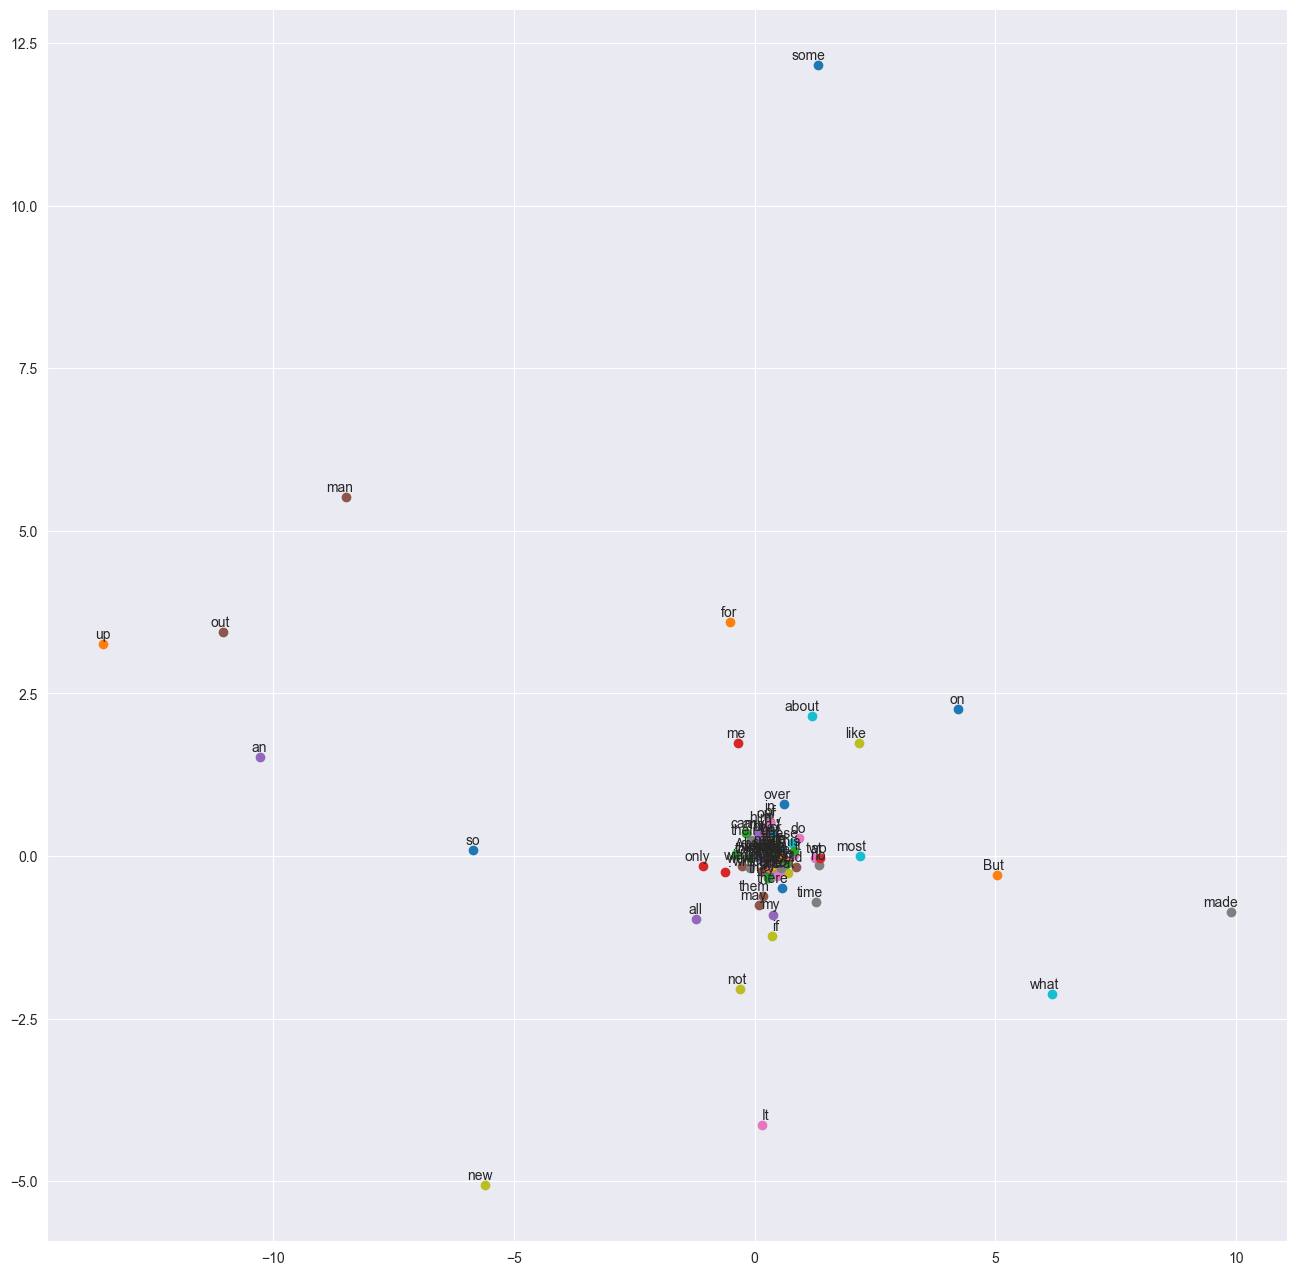

In [128]:
tsne_plot(new_model)

15173
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


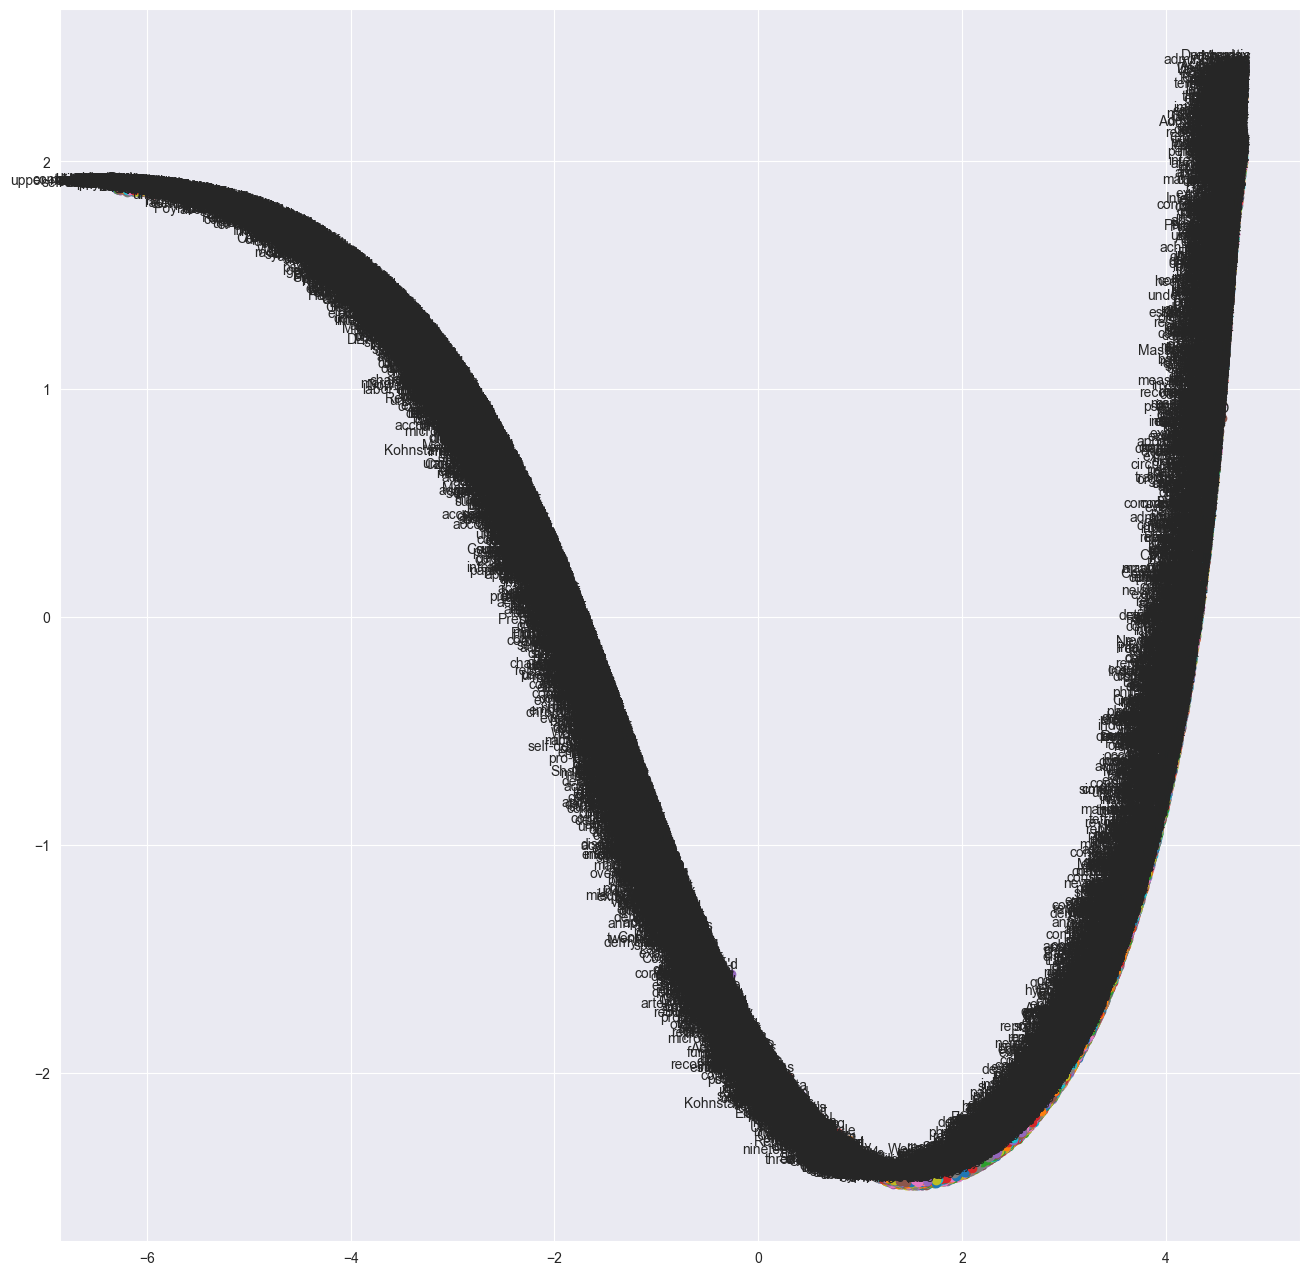

In [124]:
tsne_plot(new_model)

In [129]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
glove_vectors = gensim.downloader.load('glove-twitter-25')  
glove_vectors.most_similar('twitter')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']
[--------------------------------------------------] 0.4% 0.4/104.8MB downloaded

KeyboardInterrupt: 

# THE END

###################################################################################

# Editional Codes

In [4]:
import gensim
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')
import numpy as np
X = np.zeros(shape=(50,len(new_model.wv['university'])))
X.shape

(50, 300)

In [ ]:
# one time used 
# convert csv to tsv
import re
 
# reading given tsv file
with open("win353.csv", 'r') as myfile: 
  with open("win353.tsv", 'w') as csv_file:
    for line in myfile:
       
      # Replace every tab with comma
      fileContent = re.sub(",", "\t", line)
       
      # Writing into csv file
      csv_file.write(fileContent)
 
# output
print("Successfully made tsv file")

In [ ]:
model = gensim.models.Word2Vec(brown.sents())
model.save('./model/brown.embedding')
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')

In [ ]:
import gensim
new_model = gensim.models.Word2Vec.load('./model/brown.embedding')

In [10]:
import numpy as np
X = np.zeros(shape=(50,len(new_model.wv['university'])))
X.shape

(50, 300)

In [11]:
new_model.wv.most_similar("university")

[('college', 0.9967603087425232),
 ('opposition', 0.996311366558075),
 ('measure', 0.9961631894111633),
 ('awards', 0.9958614706993103),
 ('electricity', 0.9958468079566956),
 ('loss', 0.9956271648406982),
 ('student', 0.9955264329910278),
 ('speed', 0.9954710602760315),
 ('combination', 0.9954462647438049),
 ('neighborhood', 0.9951592683792114)]

In [ ]:
from gensim.test.utils import datapath
model_evalu= new_model.wv.evaluate_word_pairs(datapath('wordsim353.tsv'))
print(float(model_evalu[2]))

In [ ]:
CSV_NAME = 'models_eval.csv'

bats_cat_1 = "lexicographic_semantics"
bats_cat_2 = "E10 [male - female]"
bats_cat_3 = "total"

In [14]:
import gensim
from nltk.corpus import brown
brown.sents()[9]

['The',
 'City',
 'Purchasing',
 'Department',
 ',',
 'the',
 'jury',
 'said',
 ',',
 '``',
 'is',
 'lacking',
 'in',
 'experienced',
 'clerical',
 'personnel',
 'as',
 'a',
 'result',
 'of',
 'city',
 'personnel',
 'policies',
 "''",
 '.']